<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>Authors: Ilya Baryshnikov, Data Scientist at ivi.ru, [Yury Kashnitsky](https://www.linkedin.com/in/festline/), Data Scientist at Mail.Ru Group <br>
Translated and edited by Inga Kaydanova, [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), Anastasia Manokhina, and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/) 

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

# <center>Assignment # 2</center>
## <center>Analyzing cardiovascular disease data</center>  

In this assignment, you will answer questions about a dataset on cardiovascular disease. You do not need to download the data: it is already in the repository. There are some Tasks that will require you to write code. Complete them and then answer the questions in the [form](https://drive.google.com/open?id=1IpLdIncbGKLvaAAE0VBB2EBuyrJDmzUrPr4pBl8k7cI).

#### Problem

Predict the presence or absence of cardiovascular disease (CVD) using the patient examination results.

#### Data description

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

Let's get to know our data by performing a preliminary data analysis.

#  Part 1. Preliminary data analysis

First, we will initialize the environment:

In [1]:
# Import all required modules
import pandas as pd
import numpy as np

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Import plotting modules
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

You will use the `seaborn` library for visual analysis, so let's set that up too:

In [2]:
# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", 
    font_scale=1.5,       
    rc={ 
        "figure.figsize": (11, 8), 
        "axes.titlesize": 18 
    }
)

from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

To make it simple, we will work only with the training part of the dataset:

In [68]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', sep=';')
print('Dataset size: ', df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


It would be instructive to peek into the values of our variables.
 
Let's convert the data into *long* format and depict the value counts of the categorical features using [`factorplot()`](https://seaborn.pydata.org/generated/seaborn.factorplot.html).

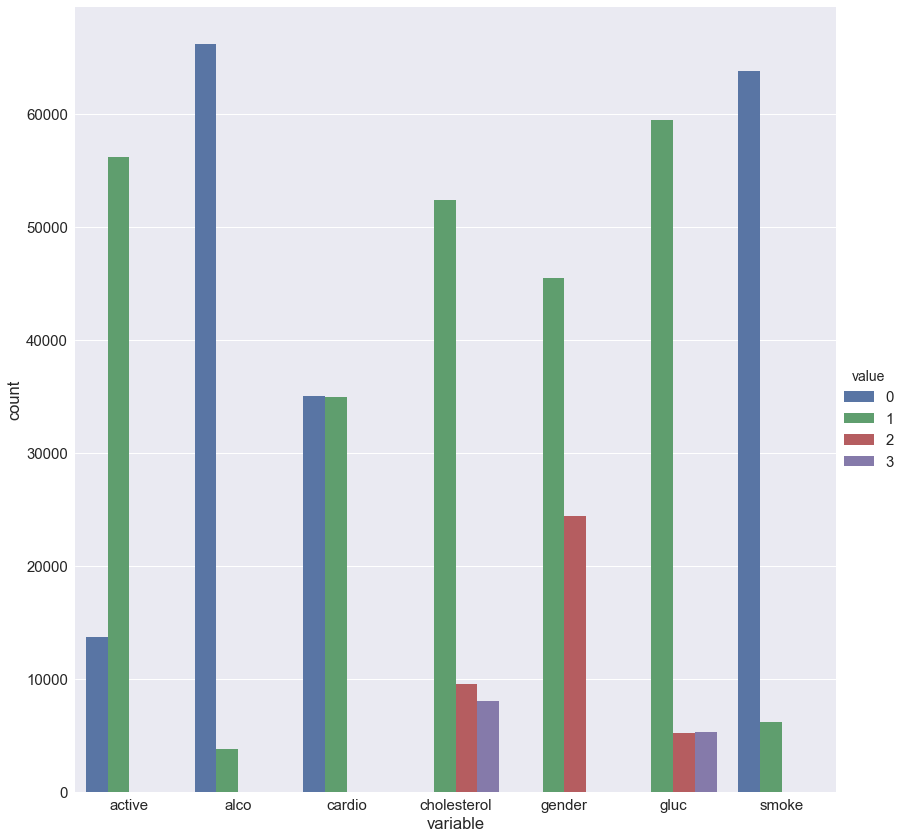

In [5]:
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active', 'cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 
                                              'value'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.factorplot(x='variable', y='count', hue='value', 
               data=df_uniques, kind='bar', size=12);

We can see that the target classes are balanced. That's great!

Let's split the dataset by target values. Can you already spot the most significant feature by just looking at the plot?

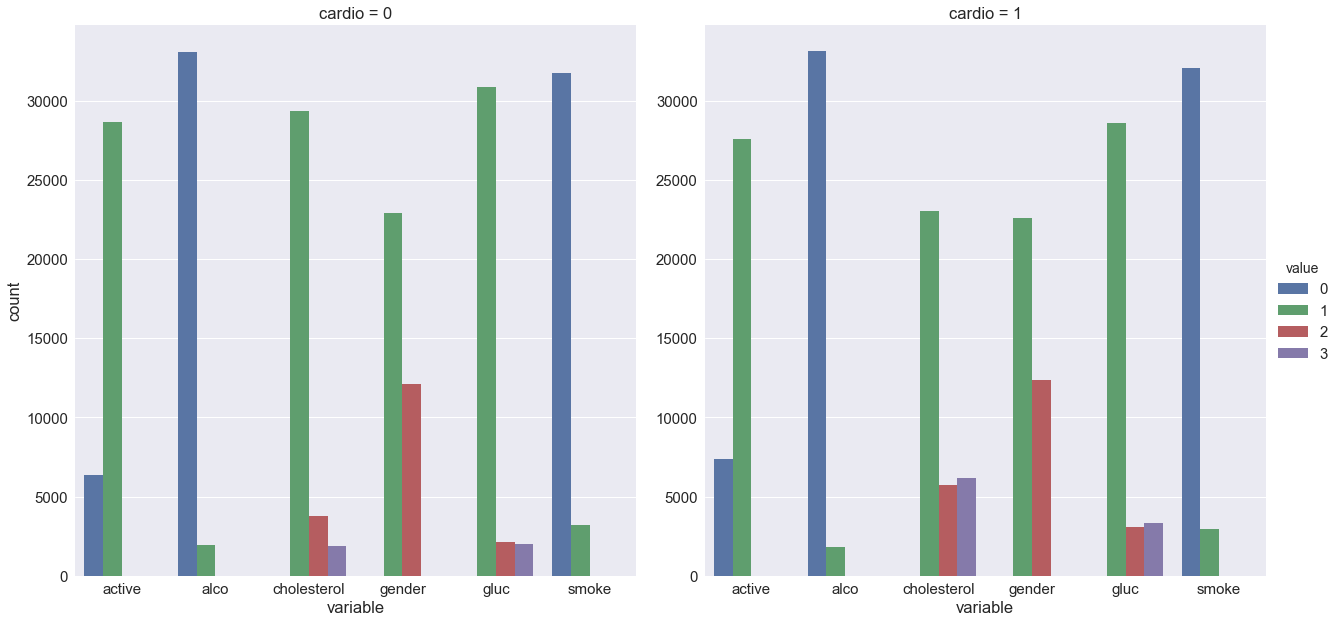

In [6]:
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active'], 
                     id_vars=['cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 'value', 
                                              'cardio'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.factorplot(x='variable', y='count', hue='value', 
               col='cardio', data=df_uniques, kind='bar', size=9);

You can see that the distribution of cholesterol and glucose levels great differs by the value of the target variable. Is this a coincidence?

Now, let's calculate some statistics for the feature unique values:

In [7]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


In the end, we have:
- 5 numerical features (excluding *id*); age, height, weight, ap_hi, ap_lo
- 7 categorical features; gender, chol, gluc, smoke, alco, active, cardio
- 70000 records in total.

## 1.1. Basic observations

**Question 1.1. (1 point). How many men and women are present in this dataset? Values of the `gender` feature were not given (whether "1" stands for women or for men) – figure this out by looking analyzing height, making the assumption that men are taller on average. **
1. 45530 women and 24470 men
2. 45530 men and 24470 women
3. 45470 women and 24530 men
4. 45470 men and 24530 women

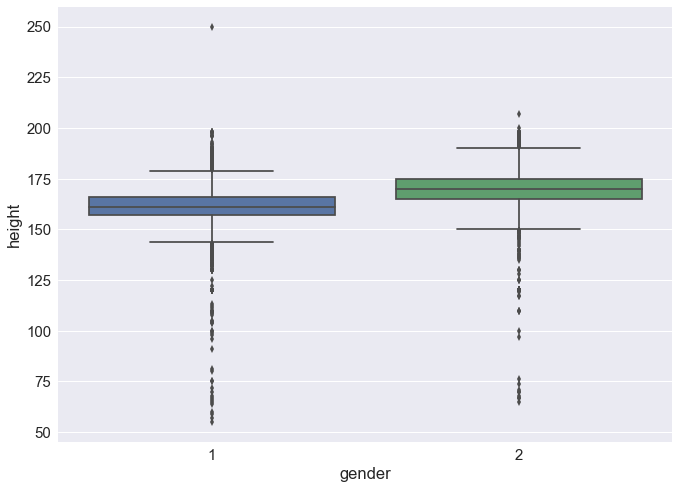

In [9]:
sns.boxplot(x='gender', y="height", data=df)

Conclusion: 2 stands for men 1 stands for women

In [69]:
df["gender"]= df["gender"].map({1:"women", 2:"men"})

df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,men,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,women,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,women,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,men,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,women,156,56.0,100,60,1,1,0,0,0,0


In [25]:
df["gender"].value_counts()

women    45530
men      24470
Name: gender, dtype: int64

**Question 1.2. (1 point). Which gender more often reports consuming alcohol - men or women?**
1. women
2. men

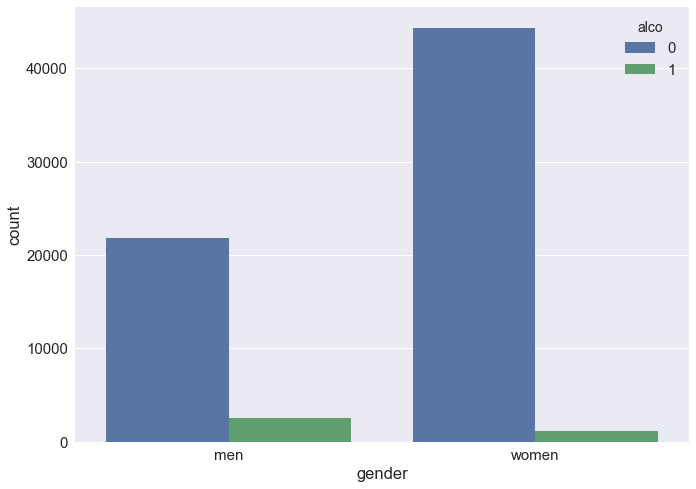

In [27]:
sns.countplot(x='gender', hue='alco', data=df);

**Question 1.3. (1 point). What is the difference between the percentages of smokers among men and women (rounded)?**
1. 4
2. 16
3. 20
4. 24

In [37]:
df[(df["gender"]== "men")]["smoke"].value_counts(normalize=True)[1]-df[(df["gender"]== "women")]["smoke"].value_counts(normalize=True)[1]

0.20102390309976736

**Question 1.4. (1 point). What is the difference between median values of age for smokers and non-smokers (rounded)? You'll need to figure out the units of feature `age` in this dataset.**

1. 5
2. 10
3. 15
4. 20

In [70]:
df["age"]=(df["age"]/365).round(decimals=0)
df.head()


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.0,men,168,62.0,110,80,1,1,0,0,1,0
1,1,55.0,women,156,85.0,140,90,3,1,0,0,1,1
2,2,52.0,women,165,64.0,130,70,3,1,0,0,0,1
3,3,48.0,men,169,82.0,150,100,1,1,0,0,1,1
4,4,48.0,women,156,56.0,100,60,1,1,0,0,0,0


In [71]:
df[(df["smoke"]== 1)]["age"].median

<bound method Series.median of 14       40.0
19       60.0
38       64.0
58       44.0
59       56.0
67       61.0
103      50.0
105      57.0
107      40.0
121      53.0
125      54.0
134      59.0
152      56.0
164      56.0
177      60.0
182      62.0
185      58.0
186      54.0
187      52.0
190      52.0
192      58.0
206      48.0
207      58.0
226      43.0
228      48.0
230      64.0
232      51.0
237      47.0
244      48.0
246      40.0
         ... 
69626    54.0
69647    50.0
69654    52.0
69678    41.0
69694    50.0
69697    64.0
69699    64.0
69701    50.0
69710    40.0
69723    50.0
69725    44.0
69728    59.0
69758    46.0
69769    50.0
69787    55.0
69794    54.0
69814    62.0
69857    62.0
69861    47.0
69867    56.0
69869    48.0
69876    52.0
69891    58.0
69893    54.0
69909    53.0
69950    52.0
69953    48.0
69957    43.0
69970    62.0
69995    53.0
Name: age, Length: 6169, dtype: float64>

In [72]:
df[(df["smoke"]== 0)]["age"].median

<bound method Series.median of 0        50.0
1        55.0
2        52.0
3        48.0
4        48.0
5        60.0
6        61.0
7        62.0
8        48.0
9        54.0
10       62.0
11       52.0
12       41.0
13       54.0
15       46.0
16       58.0
17       46.0
18       48.0
20       54.0
21       59.0
22       63.0
23       64.0
24       46.0
25       40.0
26       54.0
27       50.0
28       40.0
29       58.0
30       50.0
31       64.0
         ... 
69968    44.0
69969    56.0
69971    55.0
69972    47.0
69973    61.0
69974    50.0
69975    58.0
69976    59.0
69977    46.0
69978    52.0
69979    61.0
69980    49.0
69981    48.0
69982    52.0
69983    54.0
69984    49.0
69985    50.0
69986    50.0
69987    52.0
69988    60.0
69989    58.0
69990    41.0
69991    56.0
69992    51.0
69993    54.0
69994    58.0
69996    62.0
69997    52.0
69998    61.0
69999    56.0
Name: age, Length: 63831, dtype: float64>

## 1.2. Risk maps
### Task:

On the website for the European Society of Cardiology, a [SCORE scale](https://www.escardio.org/Education/Practice-Tools/CVD-prevention-toolbox/SCORE-Risk-Charts) is provided. It is used for calculating the risk of death from a cardiovascular decease in the next 10 years. Here it is:
<img src='../../img/SCORE2007-eng.png' width=70%>

Let's take a look at the upper-right rectangle, which shows a subset of smoking men aged from 60 to 65. (It's not obvious, but the values in the figure represent the upper bound).

We see the value 9 in the lower-left corner of the rectangle and 47 in the upper-right. This means that, for people in this gender-age group whose systolic pressure is less than 120, the risk of a CVD is estimated to be 5 times lower than for those with the pressure in the interval [160,180).

Let's calculate that same ratio using our data.

Clarifications:
- Calculate ``age_years`` feature – round age to the nearest number of years. For this task, select only the people of age 60 to 64, inclusive.
- Cholesterol level categories differ between the figure and our dataset. The conversion for the ``cholesterol`` feature is as follows: 4 mmol/l $\rightarrow$ 1, 5-7 mmol/l $\rightarrow$ 2, 8 mmol/l $\rightarrow$ 3.

In [75]:
df1 = df[(df["age"]>=60.0) & (df["age"]<65.0)]
df1["cholesterol"]= df1["cholesterol"].map({1:"4", 2:"5-7", 3:"8"})

df1.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
5,8,60.0,women,151,67.0,120,80,5-7,2,0,0,0,0
6,9,61.0,women,157,93.0,130,80,8,1,0,0,1,0
7,12,62.0,men,178,95.0,130,90,8,3,0,0,1,1
10,15,62.0,women,169,80.0,120,80,4,1,0,0,1,0
19,29,60.0,men,162,56.0,120,70,4,1,1,0,1,0


**Question 1.5. (2 points). Calculate the fraction of the people with CVD for the two segments described above. What is the ratio of these two fractions?**

1. 1
2. 2
3. 3
4. 4

In [76]:
df2 = df1[(df1["smoke"]==1) & (df1["gender"]=="men")]
df2.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
19,29,60.0,men,162,56.0,120,70,4,1,1,0,1,0
38,52,64.0,men,162,72.0,130,80,4,1,1,0,1,1
67,90,61.0,men,171,97.0,150,100,8,1,1,0,1,1
177,240,60.0,men,170,69.0,120,80,4,1,1,1,1,0
182,248,62.0,men,174,74.0,130,80,8,1,1,0,1,1


In [85]:
df2[(df2["ap_hi"]>=160) & (df2["ap_hi"]<180) & (df2["cholesterol"]=="8")]["cardio"].value_counts()

1    19
0     3
Name: cardio, dtype: int64

In [86]:
df2[(df2["ap_hi"]>=0) & (df2["ap_hi"]<120) & (df2["cholesterol"]=="4")]["cardio"].value_counts()

0    58
1    20
Name: cardio, dtype: int64

In [87]:
58/19

3.0526315789473686

## 1.3. Analyzing BMI
### Task:

Create a new feature – BMI ([Body Mass Index](https://en.wikipedia.org/wiki/Body_mass_index)). To do this, divide weight in kilogramms by the square of the height in meters. Normal BMI values are said to be from 18.5 to 25. 

In [95]:
df["BMI"] = df.apply(lambda row: row.weight/((row.height/100)*(row.height/100)), axis=1)
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,0,50.0,men,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,1,55.0,women,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,2,52.0,women,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,3,48.0,men,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,4,48.0,women,156,56.0,100,60,1,1,0,0,0,0,23.011177


In [96]:
df["BMI"]=df["BMI"].round(decimals=0)
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,0,50.0,men,168,62.0,110,80,1,1,0,0,1,0,22.0
1,1,55.0,women,156,85.0,140,90,3,1,0,0,1,1,35.0
2,2,52.0,women,165,64.0,130,70,3,1,0,0,0,1,24.0
3,3,48.0,men,169,82.0,150,100,1,1,0,0,1,1,29.0
4,4,48.0,women,156,56.0,100,60,1,1,0,0,0,0,23.0


In [97]:
df["BMI"].describe()

count    70000.000000
mean        27.548886
std          6.099019
min          3.000000
25%         24.000000
50%         26.000000
75%         30.000000
max        299.000000
Name: BMI, dtype: float64

**Question 1.6. (2 points). Choose the correct statements:**

1. Median BMI in the sample is within the range of normal BMI values.
2. The BMI for women is on average higher than for men.
3. Healthy people have, on average, a higher BMI than the people with CVD.
4. For healthy, non-drinking men, BMI is closer to the norm than for healthy, non-drinking women

In [98]:
df["BMI"].median()

26.0

In [99]:
df[df["gender"]=="women"]["BMI"].mean()

27.980430485394244

In [100]:
df[df["gender"]=="men"]["BMI"].mean()

26.74593379648549

In [101]:
df[df["cardio"]== 1]["BMI"].mean()

28.557420166385544

In [102]:
df[df["cardio"]== 0]["BMI"].mean()

26.541560777819022

In [103]:
df[(df["cardio"]== 0)&(df["alco"]== 0)&(df["gender"]== "men")]["BMI"].mean()

25.864253814663194

In [104]:
df[(df["cardio"]== 0)&(df["alco"]== 0)&(df["gender"]== "women")]["BMI"].mean()

26.840318825004477

## 1.4. Cleaning data

### Task:
We can see that the data is not perfect. It contains "dirt" and inaccuracies. We'll see this better as we visualize the data.

Filter out the following patient segments (we consider these as erroneous data)

- diastolic pressure is higher than systolic 
- height is strictly less than 2.5 percentile (Use `pd.Series.quantile` to compute this value. If you are not familiar with the function, please read the docs.)
- height is strictly higher than 97.5 percentile
- weight is strictly less than 2.5 percentile
- height is strictly more than 97.5 percentile

This is not everything that we can do to clean this data, but this is sufficient for now.

In [107]:
len(df[df["ap_lo"]>df["ap_hi"]].index)

1234

In [110]:
len(df[df["height"]<df["height"].quantile(0.025)].index)

1537

In [111]:
len(df[df["height"]>df["height"].quantile(0.975)].index)

1439

In [113]:
len(df[df["weight"]<df["weight"].quantile(0.025)].index)

1490

In [114]:
len(df[df["weight"]>df["weight"].quantile(0.975)].index)

1613

In [133]:
dfcopy = df.drop(df[(df["ap_lo"]>df["ap_hi"])|(df["height"]<df["height"].quantile(0.025))|(df["height"]>df["height"].quantile(0.975))\
|(df["weight"]<df["weight"].quantile(0.025))|(df["weight"]>df["weight"].quantile(0.975))].index) 
100*(len(df.index)-len(dfcopy.index))/len(df.index)
#df = df.drop(df[df.score < 50].index)

9.63

In [174]:
70000-len(dfcopy.index)

6741

In [175]:
1234+1613+1490+1439+1537

7313

**Question 1.7. (2 points). What percent of the original data (rounded) did we throw away?**

1. 8
2. 9
3. 10
4. 11

# Part 2. Visual data analysis

## 2.1. Correlation matrix visualization

To understand the features better, you can create a matrix of the correlation coefficients between the features. Use the initial dataset (non-filtered).

### Task:

Plot a correlation matrix using [`heatmap()`](http://seaborn.pydata.org/generated/seaborn.heatmap.html). You can create the matrix using the standard `pandas` tools with the default parameters.

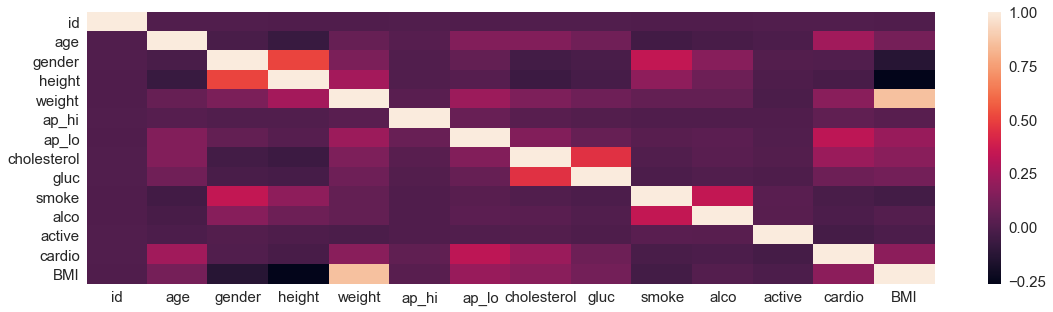

In [176]:
df["gender"]= df["gender"].map({"women":1, "men":2})
dfcopy["gender"]= dfcopy["gender"].map({"women":1, "men":2})
corr_matrix = dfcopy.corr()
sns.heatmap(corr_matrix)

** Question 2.1. (1 point).** Which pair of features has the strongest Pearson's correlation with the *gender* feature?

1. Cardio, Cholesterol
2. Height, Smoke
3. Smoke, Alco
4. Height, Weight

## 2.2. Height distribution of men and women

From our exploration of the unique values earlier, we know that the gender is encoded by the values *1* and *2*. Although you do not know the mapping of these values to gender, you can figure that out graphically by looking at the mean values of height and weight for each value of the *gender* feature.

### Task:

Create a violin plot for the height and gender using [`violinplot()`](https://seaborn.pydata.org/generated/seaborn.violinplot.html). Use the parameters:
- `hue` to split by gender;
- `scale` to evaluate the number of records for each gender.

In order for the plot to render correctly, you need to convert your `DataFrame` to *long* format using the `melt()` function from `pandas`. Here is [an example](https://stackoverflow.com/a/41575149/3338479) of this for your reference.

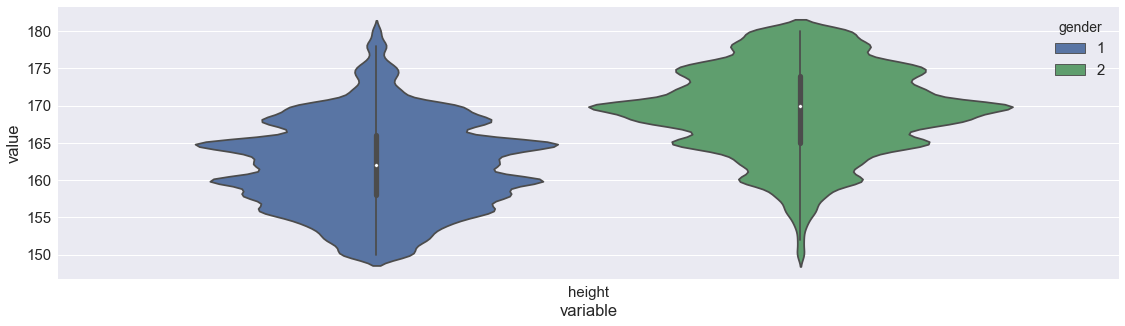

In [177]:
dfnow = pd.melt(dfcopy, value_vars=['height'], id_vars='gender')
sns.violinplot(x='variable', y='value', hue='gender', data=dfnow)
plt.show()

**Question 2.2. (1 point).** Which pair of features has the strongest Spearman correlation?

1. Height, Weight
2. Age, Weight
3. Cholesterol, Gluc
4. Cardio, Cholesterol
5. Ap_hi, Ap_lo
6. Smoke, Alco

In [178]:
dfsp = dfcopy.corr(method='spearman')
dfsp

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
id,1.000000,0.001478,0.003727,0.000802,0.000634,0.005825,0.001021,0.004494,0.002312,-0.002741,-0.000716,0.005914,0.003899,-0.000556
age,0.001478,1.000000,-0.015729,-0.075043,0.071877,0.223314,0.159580,0.142065,0.090762,-0.044027,-0.027226,-0.011556,0.237823,0.110506
gender,0.003727,-0.015729,1.000000,0.510813,0.141272,0.059131,0.059237,-0.038729,-0.021881,0.337855,0.168887,0.007791,0.002349,-0.106843
height,0.000802,-0.075043,0.510813,1.000000,0.262531,0.005737,0.015586,-0.066984,-0.031342,0.187564,0.088116,-0.004826,-0.023685,-0.230110
weight,0.000634,0.071877,0.141272,0.262531,1.000000,0.257434,0.231913,0.133133,0.100072,0.060794,0.060163,-0.011813,0.168049,0.856173
ap_hi,0.005825,0.223314,0.059131,0.005737,0.257434,1.000000,0.736208,0.204520,0.097666,0.024877,0.030566,-0.000420,0.447185,0.255642
ap_lo,0.001021,0.159580,0.059237,0.015586,0.231913,0.736208,1.000000,0.162013,0.074264,0.022317,0.033251,0.004430,0.350219,0.225539
cholesterol,0.004494,0.142065,-0.038729,-0.066984,0.133133,0.204520,0.162013,1.000000,0.407645,0.010230,0.036269,0.004398,0.212815,0.167447
gluc,0.002312,0.090762,-0.021881,-0.031342,0.100072,0.097666,0.074264,0.407645,1.000000,-0.005629,0.012451,-0.009680,0.089192,0.117201
smoke,-0.002741,-0.044027,0.337855,0.187564,0.060794,0.024877,0.022317,0.010230,-0.005629,1.000000,0.341200,0.026940,-0.020345,-0.029775


**Question 2.3. (1 point).** Why do these features have strong rank correlation?

1. Inaccuracies in the data (data acquisition errors).
2. Relation is wrong, these features should not be related.
3. Nature of the data.

## 2.4. Age

Previously, we calculated the age of the respondents in years at the moment of examination.

### Task:

Create a *count plot* using [`countplot()`](http://seaborn.pydata.org/generated/seaborn.countplot.html) with the age on the *X* axis and the number of people on the *Y* axis. Your resulting plot should have two columns for each age, corresponding to the number of people for each *cardio* class of that age.

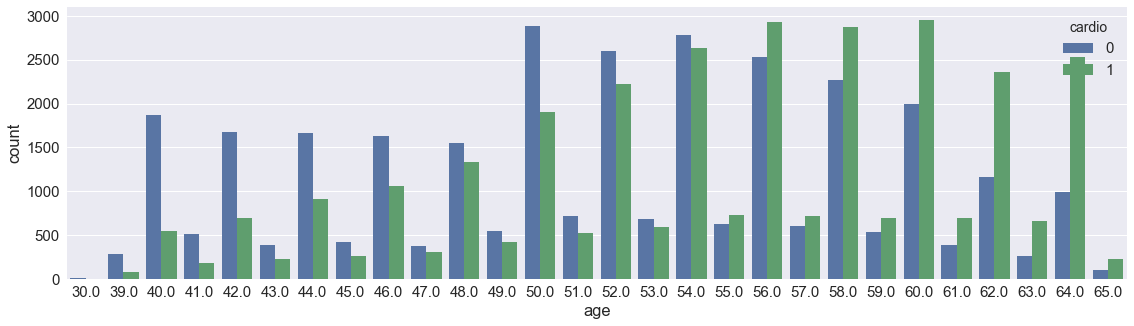

In [179]:
#dfcopy1 = df["age"].to_numeric()
from pylab import rcParams
rcParams['figure.figsize'] = 19, 5
sns.countplot(data = dfcopy, x="age", hue="cardio")

**Question 2.4. (1 point).** What is the smallest age at which the number of people with CVD outnumber the number of people without CVD?

1. 44
2. 55
3. 64
4. 70